Especialitzacions de Ciència de Dades - Spatial Data

David Galera, Maig 2023

#Importació de moduls i dades

In [ ]:
!pip install geopandas

In [ ]:
!pip install folium

In [ ]:
!pip install geom-median #Implementation of the smoothed Weiszfeld algorithm to compute the geometric median

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from geom_median.numpy import compute_geometric_median

In [5]:
madrid = gpd.read_file('/content/madrid.geojson')

In [6]:
bicimad=pd.read_csv('/content/biciMadrid.csv')

#Visualització dels districtes (polygons)


In [7]:
madrid.head()

,name,cartodb_id,created_at,updated_at,geometry
0,Centro,1,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-3.69185 40.40853, -3.69189 40..."
1,Arganzuela,2,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-3.70258 40.40638, -3.70166 40..."
2,Retiro,3,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-3.66279 40.40971, -3.66384 40..."
3,Salamanca,4,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-3.65809 40.43945, -3.65828 40..."
4,Chamartin,5,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-3.67231 40.48388, -3.67237 40..."


In [8]:
madrid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Canviem el CRS a EPSG=3857 per calcular l'àrea dels poligons en metres quadrats

In [9]:
madrid['geometry']=madrid.geometry.to_crs(epsg=3857) #Canviem el CRS

In [10]:
madrid.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
madrid['area']=madrid.geometry.area/1000000 #area en km**2

In [12]:
madrid.head()

,name,cartodb_id,created_at,updated_at,geometry,area
0,Centro,1,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-410975.196 4925487.119, -4109...",9.040900
1,Arganzuela,2,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-412168.986 4925173.095, -4120...",11.169075
2,Retiro,3,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-407739.472 4925659.339, -4078...",9.443753
3,Salamanca,4,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-407216.827 4930009.551, -4072...",9.313870
4,Chamartin,5,2013-12-02 07:20:26+01:00,2013-12-02 07:20:26+01:00,"MULTIPOLYGON (((-408799.345 4936510.160, -4088...",15.867085


In [13]:
madrid['geometry']=madrid.geometry.to_crs(epsg=4326)#Restablim el CRS original

In [14]:
madrid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

FOLIUM

In [17]:
madrid=madrid[['name','geometry','area']]

Afegim les coordenades dels centroides de cada districte

In [18]:
for row in madrid.iterrows():
  madrid.loc[row[0],'lng']=row[1]['geometry'].centroid.x
  madrid.loc[row[0],'lat']=row[1]['geometry'].centroid.y

In [19]:
madrid.head()

,name,geometry,area,lng,lat
0,Centro,"MULTIPOLYGON (((-3.69185 40.40853, -3.69189 40...",9.040900,-3.703970,40.418501
1,Arganzuela,"MULTIPOLYGON (((-3.70258 40.40638, -3.70166 40...",11.169075,-3.695493,40.399194
2,Retiro,"MULTIPOLYGON (((-3.66279 40.40971, -3.66384 40...",9.443753,-3.675252,40.412416
3,Salamanca,"MULTIPOLYGON (((-3.65809 40.43945, -3.65828 40...",9.313870,-3.672498,40.431357
4,Chamartin,"MULTIPOLYGON (((-3.67231 40.48388, -3.67237 40...",15.867085,-3.676813,40.458644


In [15]:
madrid_center=Point(40.416775, -3.703790)#coordenades del centre de madrid

Creem el folium dels districtes

In [16]:
m=folium.Map(location=(40.416775, -3.703790),zoom_start=12)#(latitude,longitude)

In [20]:
for row in madrid.iterrows():
  row_values=row[1]
  location=[row_values['lat'],row_values['lng']]
  popup = str(row_values['name'])
  marker = folium.Marker(location = location, popup = popup) #centroide dels districtes
  marker.add_to(m)

In [21]:
folium.GeoJson(madrid.geometry).add_to(m) #area dels districtes(polygons)

In [22]:
display(m) #21 districtes amb el seu centroide

#Estacions de BiciMAD



In [23]:
bicimad.reset_index(inplace=True)

In [24]:
bicimad.head()

,level_0,level_1,unlock_station_name;geolocation_unlock
0,27 - Huertas;{'type': 'Point','coordinates': [-3.6956178,40.4132798]}
1,48 - Embajadores 2;{'type': 'Point','coordinates': [-3.7022591,40.4056107]}
2,65 - Antonio Maura;{'type': 'Point','coordinates': [-3.6894193,40.4166834]}
3,102 - Velázquez;{'type': 'Point','coordinates': [-3.6840229,40.4211802]}
4,144 - Juan Bravo 50;{'type': 'Point','coordinates': [-3.6758555,40.4323655]}


In [25]:
bicimad.columns=['name','lng','lat']

In [26]:
bicimad.head()

,name,lng,lat
0,27 - Huertas;{'type': 'Point','coordinates': [-3.6956178,40.4132798]}
1,48 - Embajadores 2;{'type': 'Point','coordinates': [-3.7022591,40.4056107]}
2,65 - Antonio Maura;{'type': 'Point','coordinates': [-3.6894193,40.4166834]}
3,102 - Velázquez;{'type': 'Point','coordinates': [-3.6840229,40.4211802]}
4,144 - Juan Bravo 50;{'type': 'Point','coordinates': [-3.6758555,40.4323655]}


In [27]:
import re

Apliquem regex per extreure les coordenades de les strings

In [28]:
for row in bicimad.iterrows():
  bicimad.loc[row[0],'lng']=float(re.findall("\-\d+\.\d+",row[1]['lng'])[0])#regex
  bicimad.loc[row[0],'lat']=float(re.findall("\d+\.\d+",row[1]['lat'])[0])

In [29]:
bicimad.head()

,name,lng,lat
0,27 - Huertas;{'type': 'Point',-3.695618,40.41328
1,48 - Embajadores 2;{'type': 'Point',-3.702259,40.405611
2,65 - Antonio Maura;{'type': 'Point',-3.689419,40.416683
3,102 - Velázquez;{'type': 'Point',-3.684023,40.42118
4,144 - Juan Bravo 50;{'type': 'Point',-3.675855,40.432366


Creem el folium de les stacions de BiciMAD

In [30]:
m2=folium.Map(location=(40.416775, -3.703790),zoom_start=12)#(latitude,longitude)

In [31]:
for row in bicimad.iterrows():
  row_values=row[1]
  location=[row_values['lat'],row_values['lng']]
  marker = folium.Marker(location = location) #estacions
  marker.add_to(m2)

In [32]:
folium.GeoJson(madrid.geometry).add_to(m2) #area dels districtes(polygons)

In [33]:
display(m2) #estacions de bicimad per districte

Podem veure com hi ha districtes que no tenen cap estació.

#Quantes estacions hi ha a cada districte? (SPATIAL JOIN)

Creem la geometria de Points per cada estació a partir de la longitud i la latitud.

In [34]:
bicimad['geometry']=bicimad.apply(lambda x: Point((x.lng,x.lat)),axis=1)

In [35]:
bicimad.head()

,name,lng,lat,geometry
0,27 - Huertas;{'type': 'Point',-3.695618,40.41328,POINT (-3.6956178 40.4132798)
1,48 - Embajadores 2;{'type': 'Point',-3.702259,40.405611,POINT (-3.7022591 40.4056107)
2,65 - Antonio Maura;{'type': 'Point',-3.689419,40.416683,POINT (-3.6894193 40.4166834)
3,102 - Velázquez;{'type': 'Point',-3.684023,40.42118,POINT (-3.6840229 40.4211802)
4,144 - Juan Bravo 50;{'type': 'Point',-3.675855,40.432366,POINT (-3.6758555 40.4323655)


In [36]:
bicimad=gpd.GeoDataFrame(bicimad,crs=madrid.crs,geometry=bicimad.geometry)

In [37]:
bicimad.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Calculem les estacions que hi ha a cada districte: spatial join.

In [38]:
stations_within_district=gpd.sjoin(bicimad,madrid,op='within')#punts(estacions) dins districtes(poligons)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [39]:
stations_within_district.head()

,name_left,lng_left,lat_left,geometry,index_right,name_right,area,lng_right,lat_right
0,27 - Huertas;{'type': 'Point',-3.695618,40.41328,POINT (-3.69562 40.41328),0,Centro,9.0409,-3.70397,40.418501
10,36 - Plaza Ramales;{'type': 'Point',-3.71183,40.4168,POINT (-3.71183 40.41680),0,Centro,9.0409,-3.70397,40.418501
11,20a - Banco de España A;{'type': 'Point',-3.695461,40.419234,POINT (-3.69546 40.41923),0,Centro,9.0409,-3.70397,40.418501
15,34 - Jacinto Benavente;{'type': 'Point',-3.703683,40.414676,POINT (-3.70368 40.41468),0,Centro,9.0409,-3.70397,40.418501
16,18 - Plaza de Pedro Zerolo;{'type': 'Point',-3.69965,40.420777,POINT (-3.69965 40.42078),0,Centro,9.0409,-3.70397,40.418501


Les agrupem per districte i fem el recompte.

In [40]:
within_df=stations_within_district.groupby('name_right').size().sort_values(ascending=False) #només 15/21 districtes tenen estacions

In [41]:
within_df

name_right
Centro                 62
Salamanca              37
Arganzuela             30
Chamberi               29
Retiro                 26
Chamartin              17
Moncloa-Aravaca        17
Tetuan                 13
Ciudad Lineal          10
Moratalaz               4
Puente de Vallecas      4
Latina                  3
Carabanchel             2
Fuencarral-El Pardo     2
Usera                   2
dtype: int64

Transformem aquest recompte en un DataFrame

In [42]:
within_df=within_df.to_frame().reset_index()

In [43]:
within_df.columns=['name','counts']

In [44]:
within_df.head()

,name,counts
0,Centro,62
1,Salamanca,37
2,Arganzuela,30
3,Chamberi,29
4,Retiro,26


El fusionem amb el GeoDataFrame dels districtes

In [45]:
madrid_with_counts=pd.merge(madrid,within_df,on='name')

In [46]:
madrid_with_counts.head(5)

,name,geometry,area,lng,lat,counts
0,Centro,"MULTIPOLYGON (((-3.69185 40.40853, -3.69189 40...",9.040900,-3.703970,40.418501,62
1,Arganzuela,"MULTIPOLYGON (((-3.70258 40.40638, -3.70166 40...",11.169075,-3.695493,40.399194,30
2,Retiro,"MULTIPOLYGON (((-3.66279 40.40971, -3.66384 40...",9.443753,-3.675252,40.412416,26
3,Salamanca,"MULTIPOLYGON (((-3.65809 40.43945, -3.65828 40...",9.313870,-3.672498,40.431357,37
4,Chamartin,"MULTIPOLYGON (((-3.67231 40.48388, -3.67237 40...",15.867085,-3.676813,40.458644,17


Calculem la densitat d'estacions (estacions/km^2) de cada districte 

In [47]:
madrid_with_counts['densitat']=madrid_with_counts.apply(lambda row: row.counts/row.area,axis=1)#estacions/km^2

In [48]:
madrid_with_counts.head(5)

,name,geometry,area,lng,lat,counts,densitat
0,Centro,"MULTIPOLYGON (((-3.69185 40.40853, -3.69189 40...",9.040900,-3.703970,40.418501,62,6.857724
1,Arganzuela,"MULTIPOLYGON (((-3.70258 40.40638, -3.70166 40...",11.169075,-3.695493,40.399194,30,2.685988
2,Retiro,"MULTIPOLYGON (((-3.66279 40.40971, -3.66384 40...",9.443753,-3.675252,40.412416,26,2.753143
3,Salamanca,"MULTIPOLYGON (((-3.65809 40.43945, -3.65828 40...",9.313870,-3.672498,40.431357,37,3.972570
4,Chamartin,"MULTIPOLYGON (((-3.67231 40.48388, -3.67237 40...",15.867085,-3.676813,40.458644,17,1.071400


Creem un Folium map Cloropleth: Densitat d'estacions per districte

In [49]:
m3=folium.Map(location=(40.416775, -3.703790),zoom_start=12)#(latitude,longitude)

In [50]:
folium.Choropleth(
    geo_data=madrid_with_counts,
    name='geometry',
    data=madrid_with_counts,
    columns=['name', 'densitat'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.8,
    line_opacity=1.0,
    legend_name='Estacions BiciMAD per km quadrad'
).add_to(m3)

In [51]:
folium.LayerControl().add_to(m3)

In [52]:
for row in madrid_with_counts.iterrows():
  row_values=row[1]
  location=[row_values['lat'],row_values['lng']]
  popup = str(row_values['name'])
  popup = ('Districte: ' + str(row_values['name']) + ';  ' + "Número d'estacions: " + str(row_values['counts']))
  marker = folium.Marker(location = location, popup = popup) #centroide dels districtes
  marker.add_to(m3)

In [53]:
display(m3)

#Voronoi diagram de les estacions al barri de Chamartin

Fem un subset de les estacions ubicades al barri de Chamartin

In [54]:
Chamartin_stations=stations_within_district[stations_within_district['name_right']=='Chamartin']

In [55]:
Chamartin_stations.head()

,name_left,lng_left,lat_left,geometry,index_right,name_right,area,lng_right,lat_right
12,197 - Parque Berlín;{'type': 'Point',-3.678056,40.451583,POINT (-3.67806 40.45158),4,Chamartin,15.867085,-3.676813,40.458644
37,196 - Prosperidad;{'type': 'Point',-3.675139,40.444139,POINT (-3.67514 40.44414),4,Chamartin,15.867085,-3.676813,40.458644
85,252 - Chamartín;{'type': 'Point',-3.68391,40.4716,POINT (-3.68391 40.47160),4,Chamartin,15.867085,-3.676813,40.458644
91,255 - López Pozas;{'type': 'Point',-3.68514,40.46361,POINT (-3.68514 40.46361),4,Chamartin,15.867085,-3.676813,40.458644
98,158 - Alberto Alcocer;{'type': 'Point',-3.684715,40.458532,POINT (-3.68472 40.45853),4,Chamartin,15.867085,-3.676813,40.458644


In [56]:
Chamartin=madrid[madrid['name']=='Chamartin']

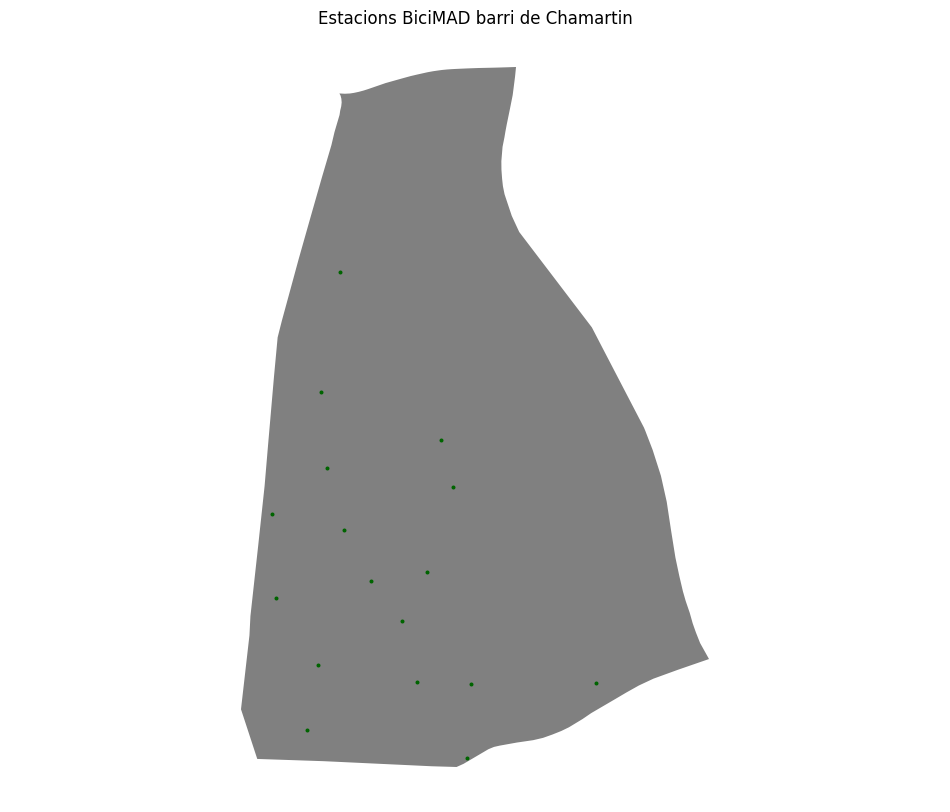

In [57]:
fig, ax = plt.subplots(figsize=(12, 10))
Chamartin.plot(ax=ax, color="gray")
Chamartin_stations.plot(ax=ax, markersize=3.5, color="darkgreen")
ax.axis("off")
plt.axis('equal')
plt.title('Estacions BiciMAD barri de Chamartin')
plt.show()

Canviem els CRS de les coordenades a World Mercator per poder treballar amb distàncies euclideas, negligint la curvatura de la terra ja que són punts molt pròxims.

In [58]:
Chamartin = Chamartin.to_crs(epsg=3395) #World Mercator or WGS 84/World Mercator coordinates
Chamartin_stations_proj = Chamartin_stations.to_crs(Chamartin.crs)

In [59]:
Chamartin.head()

,name,geometry,area,lng,lat
4,Chamartin,"MULTIPOLYGON (((-408799.345 4908763.256, -4088...",15.867085,-3.676813,40.458644


In [60]:
Chamartin_stations_proj.head()

,name_left,lng_left,lat_left,geometry,index_right,name_right,area,lng_right,lat_right
12,197 - Parque Berlín;{'type': 'Point',-3.678056,40.451583,POINT (-409439.265 4904055.238),4,Chamartin,15.867085,-3.676813,40.458644
37,196 - Prosperidad;{'type': 'Point',-3.675139,40.444139,POINT (-409114.580 4902970.481),4,Chamartin,15.867085,-3.676813,40.458644
85,252 - Chamartín;{'type': 'Point',-3.68391,40.4716,POINT (-410090.985 4906972.521),4,Chamartin,15.867085,-3.676813,40.458644
91,255 - López Pozas;{'type': 'Point',-3.68514,40.46361,POINT (-410227.908 4905807.934),4,Chamartin,15.867085,-3.676813,40.458644
98,158 - Alberto Alcocer;{'type': 'Point',-3.684715,40.458532,POINT (-410180.598 4905067.830),4,Chamartin,15.867085,-3.676813,40.458644


Guardem en una llista les coordenades de les estacions en format vector

In [61]:
l=[]
for row in Chamartin_stations_proj.iterrows():
  l.append((row[1]['geometry'].x,row[1]['geometry'].y))

Dibuixem el diagrama de Voronoi de les estacions al barri de Chamartin

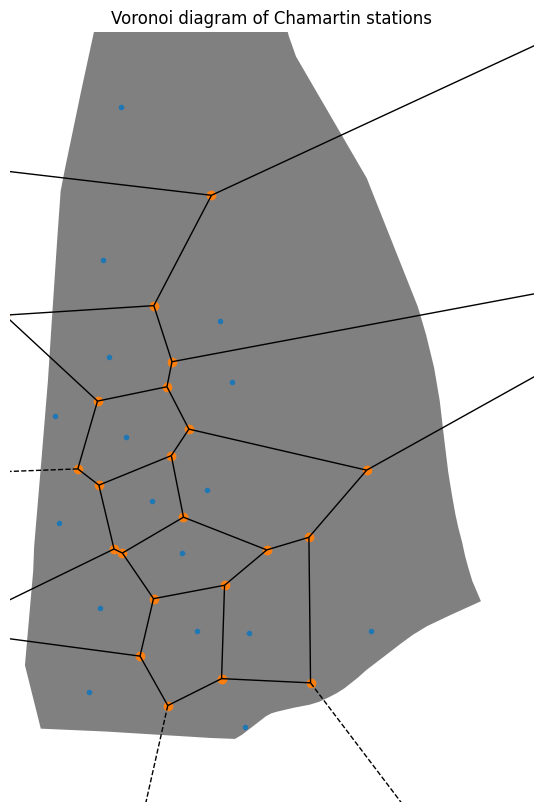

In [62]:
# Create the Voronoi diagram
vor = Voronoi(l)

# Plot the Voronoi diagram with bigger size
fig,ax = plt.subplots(figsize=(12, 10))  # set the figure size
#ax = fig.add_subplot(111)
Chamartin.plot(ax=ax, color="gray")
voronoi_plot_2d(vor, ax=ax)
plt.title('Voronoi diagram of Chamartin stations')
# Display the plot
ax.axis("off")
ax.set_xlim(ax.get_xlim()[0]-100, ax.get_xlim()[1]+1000)
ax.set_ylim(ax.get_ylim()[0]-100, ax.get_ylim()[1]+100)
plt.show()

#Quin és l'optimum facility location al barri de Chamartin?

Calculem la mediana geomètrica de les coordenades.

In [63]:
out = compute_geometric_median(np.array(l))
out.termination

'function value converged within tolerance'

In [64]:
out.median

array([-409837.81892301, 4903978.32614206])

Calculem també la mitjana aritmètica

In [65]:
aritmetic_mean=np.mean(np.array(l),axis=0)

In [66]:
Chamartin.head()

,name,geometry,area,lng,lat
4,Chamartin,"MULTIPOLYGON (((-408799.345 4908763.256, -4088...",15.867085,-3.676813,40.458644


Mostrem el gràfic amb les estacions i l'optimum facility location. On per exemple, es podria establir una oficina de suport tècnic, pròxima a totes les estacions.

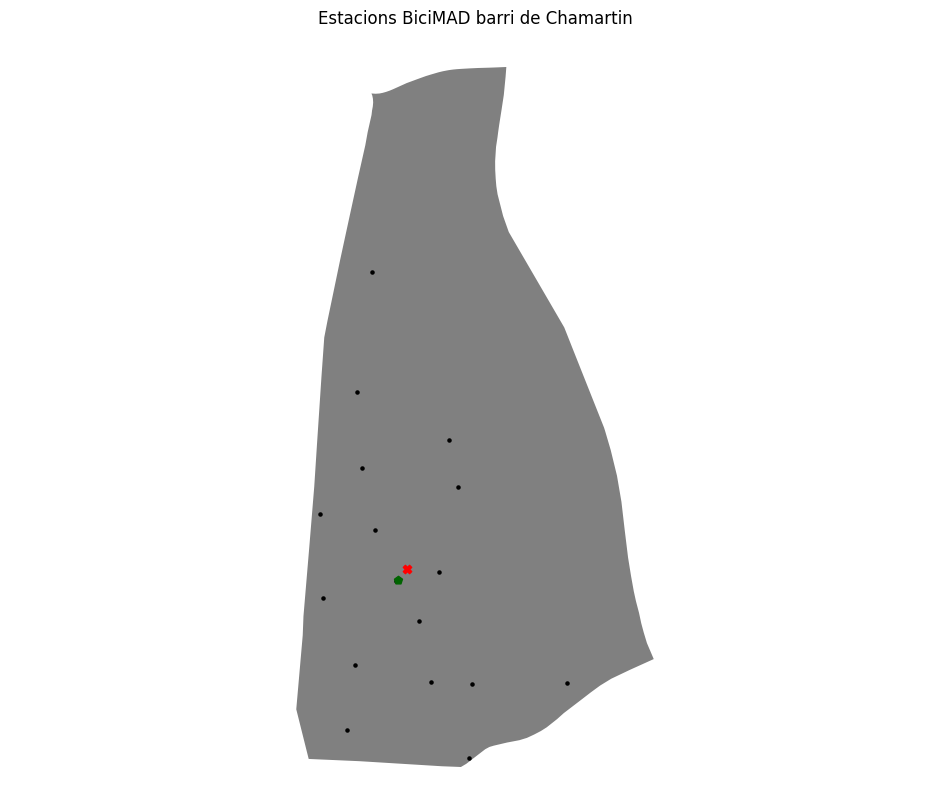

In [67]:
fig, ax = plt.subplots(figsize=(12, 10))
Chamartin.plot(ax=ax, color="gray")
Chamartin_stations_proj.plot(ax=ax, markersize=5, color="black")
plt.scatter(out.median[0],out.median[1],marker='p',c='darkgreen') #Geometric median
plt.scatter(aritmetic_mean[0],aritmetic_mean[1],marker='X',c='red') #Aritmethic mean
ax.axis("off")
plt.axis('equal')
plt.title('Estacions BiciMAD barri de Chamartin')
plt.show()